In [67]:
# les images vont être ajustées par le CNN de 256*256 à image_size*image_size
image_size = 256

# nombre epochs a réaliser par itération
n_epochs = 0

# nombre de classes
n_class = 38

# plateforme colab
is_colab_platform = False

In [68]:
if (is_colab_platform == True):
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)


In [69]:
import os
import sys

# nom du cnn
cnn_name = 'cnn_vgg16'

# Follow instructions for using kaggle with colab : https://www.kaggle.com/general/74235
if (is_colab_platform == True):
 
    # Extract the json api credentiel from kaggle
    # Load it in next cell
    ! pip install -q kaggle
    from google.colab import files
    files.upload()

    # Create a kaggle folder
    # Copy the json credentiel to it.
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/

    # Change the permissions of the file.
    ! chmod 600 ~/.kaggle/kaggle.json

    # Download the dataset zip
    ! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

    # unzip the dataset zip
    ! mkdir dataset
    ! unzip new-plant-diseases-dataset.zip -d dataset

    # !dir

    dataset_train = "dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
    dataset_valid = "dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
    dataset_test = "Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/test/"

    racine = os.sep + 'content'

    weights_path = racine + os.sep + 'drive' + os.sep + 'MyDrive' + os.sep + cnn_name + '_' + str(image_size) + '_weights'
    history_path = racine + os.sep + 'drive' + os.sep + 'MyDrive' + os.sep + cnn_name + '_' + str(image_size) + '_history'


else:

    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

    from lib import ressources as res
    racine = os.path.abspath(os.path.realpath(res.dir_root))

    weights_path = res.dir_data + os.sep + cnn_name + '_' + str(image_size) + '_weights'
    print(weights_path)

    history_path = res.dir_data + os.sep + cnn_name + '_' + str(image_size) + '_history'
    print(history_path)

    dataset_train = res.dir_dataset_train
    dataset_valid = res.dir_dataset_valid
    dataset_test = res.dir_dataset_test

# os.listdir(dataset_train)

C:\Users\NOEL\dev\python\DATA SCIENTIST\_projet\data\cnn_vgg16_256_weights
C:\Users\NOEL\dev\python\DATA SCIENTIST\_projet\data\cnn_vgg16_256_history


# Méthodes relatives au CNN
## Création du CNN
## Sauvegarde des données
## Augmentation du jeu de données

In [70]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32


from keras.applications.vgg16 import preprocess_input

train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        # data augmentation
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        zoom_range = 1.1,
        horizontal_flip = True
        )

test_data_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input)


train_set = train_data_generator.flow_from_directory(dataset_train,
            target_size = (image_size , image_size), 
            batch_size = batch_size)

test_set = test_data_generator.flow_from_directory(dataset_valid,
            target_size = (image_size , image_size), 
            batch_size = batch_size)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [71]:
# l'historique d'entrainement est concaténé avec les précédents résultats
def concatenate_histories(previous_history, training_history):
    
    train_accuracy = previous_history['accuracy'] + training_history['accuracy']
    val_accuracy = previous_history['val_accuracy'] + training_history['val_accuracy']
    train_loss = previous_history['loss'] + training_history['loss']
    val_loss = previous_history['val_loss'] + training_history['val_loss']

    history = {
        'accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'loss': train_loss,
        'val_loss': val_loss
    }

    # retourne l'historique mis à jour
    return history

In [72]:
import pickle
from shutil import copyfile
import fnmatch

# enregistre l'historique de l'entrainement et les poids du CNN
def save_data(model, new_history=None):

    # l'history est mis à jour à partir de training_history et, le cas échéant, de l'historique 
    # de l'entrainement précédent qui a été enregistré

    is_trained = os.path.isfile(history_path)

    # le CNN a déjà été entrainé : un historique d'entrainement existe déjà
    if (is_trained == True):

        previous_history = pickle.load(open(history_path, 'rb'))

        # cette fois, le CNN n'a pas été entrainé
        if (new_history == None):
            history = previous_history
        # cette fois-ci, le cnn a été entrainé
        else:
            history = concatenate_histories(previous_history, new_history)

    # c'est le premier entrainement du CNN
    else:
        history = new_history

    # history est enregistré
    pickle.dump(history, open(history_path, 'wb'))

    # les poids sont enregistrés
    model.save_weights(weights_path);

    return history



In [73]:
# le cnn est entrainé
def training(model, n_epochs):

    steps_per_epoch = train_set.n // train_set.batch_size
    validation_step = test_set.n // test_set.batch_size

    training_history = model.fit_generator(generator=train_set, 
                                epochs = n_epochs,
                                steps_per_epoch = steps_per_epoch,
                                validation_data = test_set,
                                validation_steps = validation_step)

    if (n_epochs == 0):
        history = None
    else:
        history = training_history.history

    # les données sont sauvegardées
    # en présence d'entrainement précédents, les historiques sont concaténés avec sauvegarde
    history_total = save_data(model, history)

    return history_total


# Entrainement du CNN

In [74]:
# Import des librairies pour le CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

In [75]:


# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False) 

# freeze les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

# le cnn est compilé
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# la structure du modèle est affichée
model.summary()

# le CNN est entrainé
for i in range(0, n_epochs):
    training(model, 1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 38)               

In [76]:
# les couches de convolution précédemment freezed sont partiellement unfreezed :
for layer in base_model.layers[-4:]:
    layer.trainable = True

# model.load_weights(weights_path)

# le cnn est compilé
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# la structure du modèle est affichée
model.summary()

# le CNN est entrainé
for i in range(0, n_epochs):
    training(model, 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 38)               

In [77]:
# le cnn est compilé
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# la structure du modèle est affichée
model.summary()

# le CNN est entrainé
for i in range(0, n_epochs):
    training(model, 1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 38)               

# Dataviz des résultats

In [78]:
import pandas as pd
import numpy as np

history = pickle.load(open(history_path, 'rb'))

df_history = pd.DataFrame()

for key, value in history.items():
    df_history[key] = value

n_last_history_values = 10

# description mathématique des fonctions coûts et des scores du CNN : pour derniers entrainements
print('Description mathématique des ', str(df_history.shape[0]), ' derniers epochs')
df_history[-n_last_history_values:].describe()

Description mathématique des  27  derniers epochs


,accuracy,val_accuracy,loss,val_loss
count,10.000000,10.000000,10.000000,10.000000
mean,0.936131,0.994188,0.207790,0.017942
std,0.004667,0.000563,0.015882,0.001748
min,0.925380,0.992942,0.191155,0.015688
25%,0.935144,0.993852,0.198076,0.016843
50%,0.937371,0.994479,0.203277,0.017779
75%,0.938983,0.994536,0.209994,0.018674
max,0.940694,0.994706,0.245512,0.021687


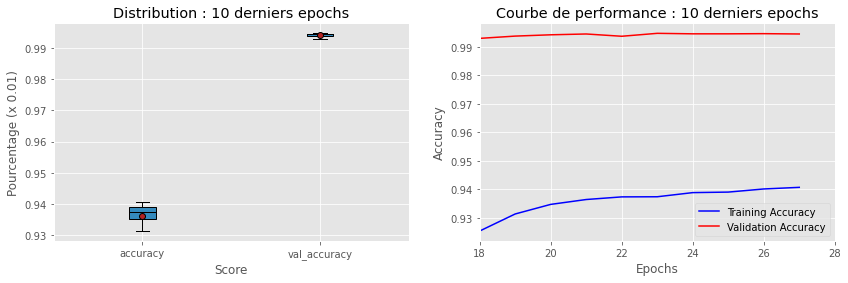

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.boxplot([df_history[-n_last_history_values:].accuracy, df_history[-n_last_history_values:].val_accuracy],
            labels=["accuracy", "val_accuracy"],
            showfliers=False, 
            medianprops=medianprops, 
            vert=True, 
            patch_artist=True, 
            showmeans=True, 
            meanprops=meanprops)

plt.title('Distribution : ' + str(len(df_history[-n_last_history_values:])) + ' derniers epochs')
plt.xlabel('Score')
plt.ylabel('Pourcentage (x 0.01)')
# plt.ylim(0.96, 1.0)

plt.subplot(122)
# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(len(df_history) - (n_last_history_values - 1) , len(df_history) + 1, 1),
         df_history[-n_last_history_values:].accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(len(df_history) - (n_last_history_values - 1) , len(df_history) + 1, 1),
         df_history[-n_last_history_values:].val_accuracy, 
         label = 'Validation Accuracy',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Courbe de performance : ' + str(n_last_history_values) + ' derniers epochs')

plt.xlim(len(df_history) - (n_last_history_values - 1) , len(df_history) + 1)
# plt.ylim(0.96, 1.0)

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show();

## Compte rendu de l'entrainement du CNN

### 7 premières epochs : 
* Entrainement avec les couches de la partie convolution figées

### 10 epochs suivantes : 
* Entrainement avec les 4 dernières couches de la partie convolution non figées
* Ajustement du learning rate avec la valeur = 10e-4

### 10 epochs suivantes :
* Entrainement avec les 4 dernières couches de la partie convolution non figées
* Ajustement du learning rate avec la valeur = 10e-5

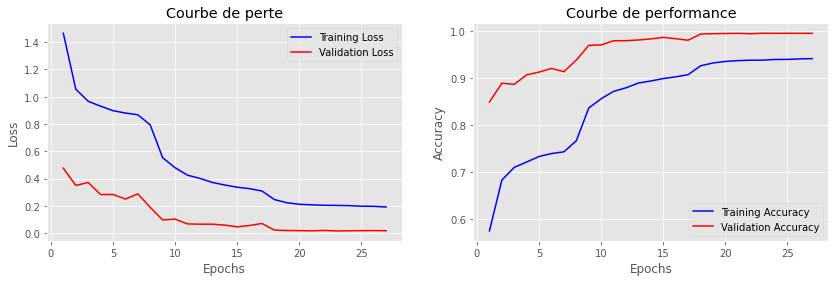

In [80]:
plt.figure(figsize=(14, 4))
plt.subplot(121)

# Courbe de la perte sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(df_history['loss']) + 1, 1),
         df_history.loss,
         label = 'Training Loss',
         color = 'blue')

# Courbe de la perte sur l'échantillon de validation
plt.plot(np.arange(1 , len(df_history['val_loss']) + 1, 1),
         df_history.val_loss, 
         label = 'Validation Loss',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Affichage de la légende
plt.legend()

# affichage du titre
plt.title('Courbe de perte')

plt.subplot(122)

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(df_history['accuracy']) + 1, 1),
         df_history.accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , len(df_history['val_accuracy']) + 1, 1),
         df_history.val_accuracy, 
         label = 'Validation Accuracy',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Affichage de la légende
plt.legend()

# affichage du titre
plt.title('Courbe de performance')

# Affichage de la figure
plt.show();


In [81]:
# Prédictions des classes : https://keras.io/api/applications/
# Paragraphe : Extract features from an arbitrary intermediate layer with VGG19

from tensorflow.keras.preprocessing import image
import numpy as np

model.load_weights(weights_path)

indice_value_classes = {v: k for k, v in train_set.class_indices.items()}

# affiche le résultat des prédictions
def predictions(files_to_predict):

    # Prédire la classe de chaque fichier
    for file in listdirectory(dataset_test):

        img = image.load_img(file, target_size=(image_size, image_size))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        predict = model.predict(img)
        classe_indices = train_set.class_indices
        indice_predict = np.argmax(predict)
        trust_rate = predict[0][indice_predict]

        file_name = os.path.split(file)[1]

        result = '\n\nFichier : \t\t' + file_name + \
                '\nClasse prédite : \t' + indice_value_classes[indice_predict] + \
                '\nIndice de confiance : \t' + str(round(trust_rate * 100, 2)) + '%'

        print(result)


In [82]:
# Récupérer la liste des fichiers à prédire
from lib.tools import listdirectory

# le jeu de données de test sert à évaluer les prédictions du CNN
predictions(listdirectory(dataset_test))





Fichier : 		AppleCedarRust1.JPG
Classe prédite : 	Apple___Cedar_apple_rust
Indice de confiance : 	100.0%


Fichier : 		AppleCedarRust2.JPG
Classe prédite : 	Apple___Cedar_apple_rust
Indice de confiance : 	100.0%


Fichier : 		AppleCedarRust3.JPG
Classe prédite : 	Apple___Cedar_apple_rust
Indice de confiance : 	100.0%


Fichier : 		AppleCedarRust4.JPG
Classe prédite : 	Apple___Cedar_apple_rust
Indice de confiance : 	100.0%


Fichier : 		AppleScab1.JPG
Classe prédite : 	Apple___Apple_scab
Indice de confiance : 	100.0%


Fichier : 		AppleScab2.JPG
Classe prédite : 	Apple___Apple_scab
Indice de confiance : 	100.0%


Fichier : 		AppleScab3.JPG
Classe prédite : 	Apple___Apple_scab
Indice de confiance : 	100.0%


Fichier : 		CornCommonRust1.JPG
Classe prédite : 	Corn_(maize)___Common_rust_
Indice de confiance : 	100.0%


Fichier : 		CornCommonRust2.JPG
Classe prédite : 	Corn_(maize)___Common_rust_
Indice de confiance : 	100.0%


Fichier : 		CornCommonRust3.JPG
Classe prédite : 	Corn_(maize)